In [3]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance

# TensorFlow/Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16  # Corrected typo in "application"
from sklearn.utils import shuffle


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


load dataset

In [6]:
train_dir = '/content/drive/MyDrive/MRI-images/Training/'
test_dir = '/content/drive/MyDrive/MRI-images/Testing/'

#load and shuffle train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
  for image in os.listdir(os.path.join(train_dir, label)):
    train_paths.append(os.path.join(train_dir, label, image))
    train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

#load and shuffle test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir, label)):
    test_paths.append(os.path.join(test_dir, label, image))
    test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)



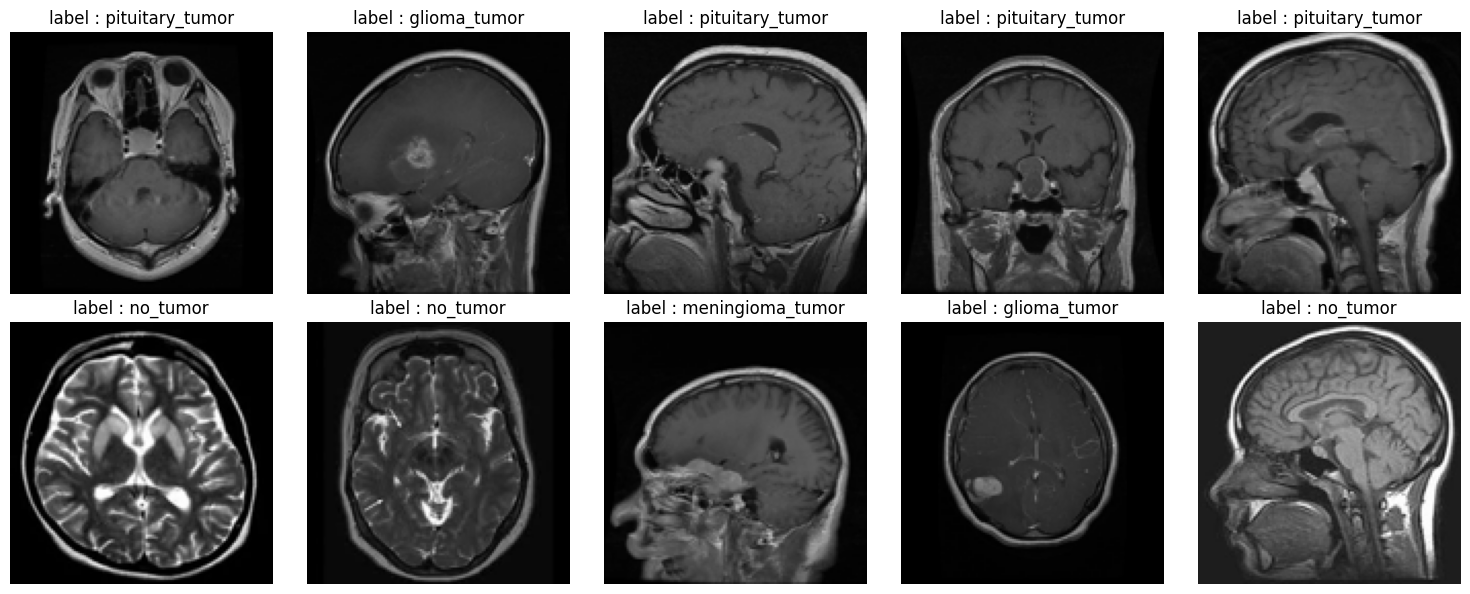

In [ ]:
import random
import matplotlib.pyplot as plt


#select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)
random_indices

#create a figure to display these 10 images in row 2 of with each row having 5 images of size 15*6 inches sq
fig, axes = plt.subplots(2,5, figsize=(15,6))
axes = axes.ravel()
#to do 1-d

for i, idx in enumerate(random_indices):
  img_path = train_paths[idx]
  img = Image.open(img_path)
  img = img.resize((128, 128))

  #display images
  axes[i].imshow(img)
  axes[i].axis('off')
  axes[i].set_title(f"label : {train_labels[idx]}")

plt.tight_layout()
plt.show()




Image processing


In [7]:
#image augmentation function
def augment_image(image):  # if 1.0> dark kardo and if 1.0< brightness badha do
  image = Image.fromarray(np.uint8(image))
  image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
  #image 2-d hota hai
  '''
  [ 0-255 value    low value-> dark    , higher value-> brighter value
    [2,3,5]
    [6,5]
    []
  ]
  to
  [20,30,50]-->[0,1,1,0] form called normalization
  '''
  image = np.array(image)/255.0
  return image


#load images and apply augmentation
def open_images(paths):
  images = []
  for path in paths :
    img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img = augment_image(img)
    images.append(img)
  return np.array(images)

#Encoder labels (convert label names to integer)
def encode_labels(labels):
  unique_labels = os.listdir(train_dir)
  encoded = [unique_labels.index(label) for label in labels]
  return np.array(encoded)


#data generator for batching to save memory , and speed
def datagen(paths, labels, batch_size=12, epochs=1):
  for _ in range(epochs):
    for i in range(0, len(paths), batch_size):
      batch_paths = paths[i:i + batch_size]
      batch_images = open_images(batch_paths)
      batch_labels = labels[i:i + batch_size]
      batch_labels = encode_labels(batch_labels)
      yield batch_images, batch_labels



In [8]:
#model architechture (128, 128 , 3) 3 color channel
IMAGE_SIZE = 128
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')


#freeze all the layers of vgg16 base model
for layer in base_model.layers:
  layer.trainable = False

#set only the last few layers
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

#build model this is CNN
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  #input layer
model.add(base_model) #VGG16 model'll be in multidimensions so flatten it to 1d
model.add(Flatten())   #flatten layer
model.add(Dropout(0.3))   #dropout layer to save model from orfeding

model.add(Dense(128, activation='relu'))  #dense layer
model.add(Dropout(0.2))   #dropping 20% of data to save ot from orfedding


model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  #model has to deal with 4 layers multiclass k model m mostly uses softmax function for activation

#compile the model
model.compile(optimizer=Adam(learning_rate=0.0001)
            ,loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])  #in case of multiclass we use this function loss='sparse_categorical_crossentropy')

#parameters

batch_size = 20
steps = int(len(train_paths) / batch_size)
epochs = 5  # can increase more

#to train model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size , epochs=epochs),
    epochs=epochs, steps_per_epoch=steps)




58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
145/145 ━━━━━━━━━━━━━━━━━━━━ 745s 5s/step - loss: 1.0059 - sparse_categorical_accuracy: 0.5673
Epoch 2/5
145/145 ━━━━━━━━━━━━━━━━━━━━ 770s 5s/step - loss: 0.3805 - sparse_categorical_accuracy: 0.8546
Epoch 3/5
145/145 ━━━━━━━━━━━━━━━━━━━━ 882s 6s/step - loss: 0.2686 - sparse_categorical_accuracy: 0.8990
Epoch 4/5
145/145 ━━━━━━━━━━━━━━━━━━━━ 742s 5s/step - loss: 0.1983 - sparse_categorical_accuracy: 0.9240
Epoch 5/5
145/145 ━━━━━━━━━━━━━━━━━━━━ 764s 5s/step - loss: 0.1796 - sparse_categorical_accuracy: 0.9288


model train plotting loss plotting
 and accuracy plotting

---



<ipython-input-9-1c2198518a99>:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


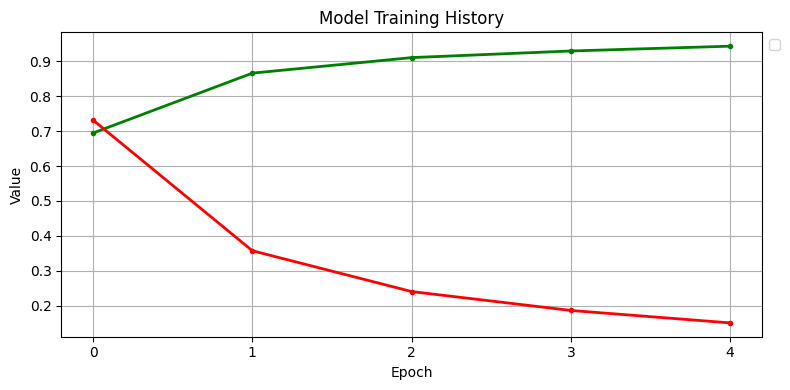

In [9]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(8, 4))
plt.grid(True)
# Plot accuracy
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)

# Plot loss
plt.plot(history.history['loss'], '.r-', linewidth=2)

# Add title, labels, and legend
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.xticks(range(epochs))  # Ensure the x-axis ticks align with the number of epochs
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot
plt.tight_layout()  # Adjust layout for better visualization
plt.show()


confusion matrix


In [10]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import numpy as np

test_images = open_images(test_paths)
test_labels_encoded = encode_labels(test_labels)

test_predictions = model.predict(test_images)

print("classification report :")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

13/13 ━━━━━━━━━━━━━━━━━━━━ 99s 7s/step
classification report :
              precision    recall  f1-score   support

           0       1.00      0.19      0.32       100
           1       0.91      0.82      0.87        74
           2       0.82      0.96      0.89       105
           3       0.60      0.97      0.74       115

    accuracy                           0.74       394
   macro avg       0.83      0.74      0.70       394
weighted avg       0.82      0.74      0.70       394



confusion matrix plotting

confusion matrix :
[[ 19   3  14  64]
 [  0  61   7   6]
 [  0   0 101   4]
 [  0   3   1 111]]


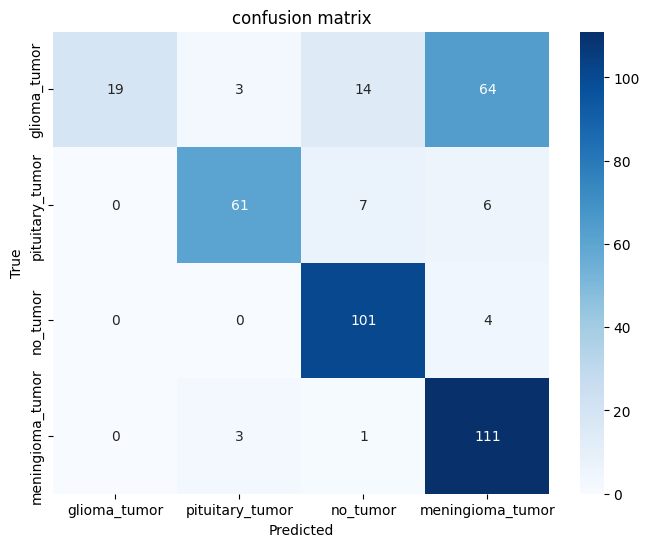

In [13]:
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("confusion matrix :")
print(conf_matrix)


plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=os.listdir(train_dir),
            yticklabels=os.listdir(train_dir))

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('confusion matrix')
plt.show()

ROC Curve

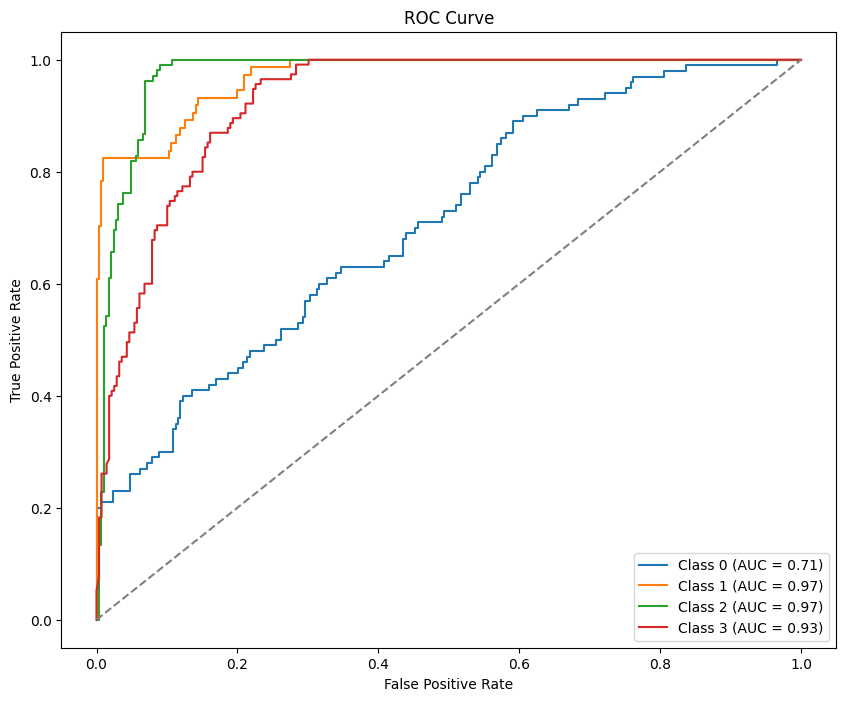

In [15]:
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # Assuming test_predictions contains the predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}

for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))

for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color="gray")  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


save and load the model

In [24]:
model.save('model.h5')

In [25]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')

In [42]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Define class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

# Function to detect and display tumor predictions
def detect_and_display(img_path, model):
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(128, 128))  # Ensure input size matches model input
        img_array = img_to_array(img)  # Convert image to array
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make predictions
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions)  # Get index of highest confidence class
        confidence_score = np.max(predictions)  # Get the highest confidence score

        # Check if the predicted class is 'notumor'
        if class_labels[predicted_class_index] == 'notumor':
            print("No tumor detected")
            plt.imshow(load_img(img_path))
        else:
            # Display result for detected tumors
            result = f"Tumor: {class_labels[predicted_class_index]}"
            plt.imshow(load_img(img_path))  # Display original image
            plt.axis('off')  # Hide axes
            plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")  # Add prediction result
            plt.show()

    except Exception as e:
        print(f"Error processing the image: {e}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
No tumor detected


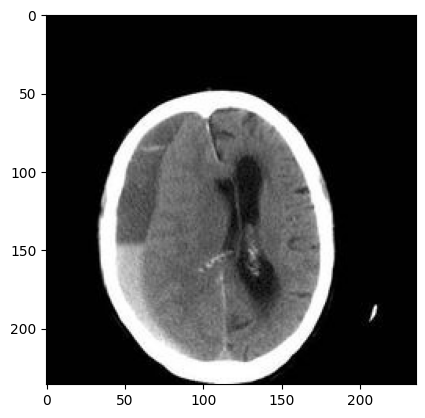

In [43]:
image_path = '/content/drive/MyDrive/MRI-images/Testing/notumor/image(1).jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
No tumor detected


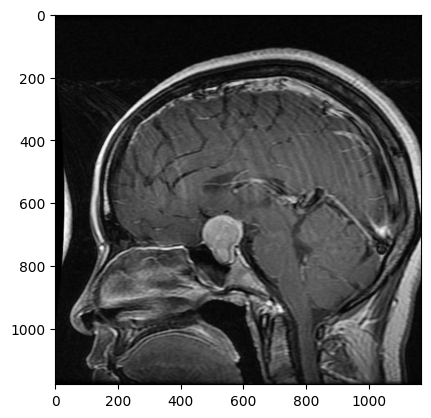

In [44]:
image_path = '/content/drive/MyDrive/MRI-images/Testing/pituitary/image(68).jpg'
detect_and_display(image_path, model)